In [1]:
# Load the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation as inter
from PIL import Image as im
import pickle
import cv2
from tqdm import tqdm
from scipy.ndimage import rotate
import time
import joblib
from sklearn.metrics import accuracy_score,f1_score,classification_report
import os
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [41]:
labels = [ 'Scheherazade New' , 'Marhey' , 'Lemonada' , 'IBM Plex Sans Arabic']
image_size = 600
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [3]:
# Load the images from fonts-dataset folder
def load_images():
    # Load the images from the fonts-dataset folder
    images_train = []
    labels_train = []
    # Use tqdm to show a progress bar
    for i in tqdm(labels):
        for filename in os.listdir(f'fonts-dataset/{i}'):
            img = cv2.imread(f'fonts-dataset/{i}/{filename}', cv2.IMREAD_GRAYSCALE)
            # img = cv2.resize(img, (image_size, image_size))
            images_train.append(img)
            labels_train.append(i)
    return images_train, labels_train



In [4]:
# Load the images
X_train, y_train = load_images()
# Change the y_train to numbers
y_train = [labels.index(i) for i in y_train]

100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


In [29]:
def find_score(arr, angle):
    """
    Find the score of the skew angle to be used in deskewing the image
    
    Args:
    arr: the image array
    angle: the angle to rotate the image by
    
    Returns:
    hist: the histogram of the image
    score: the score of the skew angle
    """
    data = rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

def deskew(binary_img):
    """
    Deskew the image
    
    Args:
    binary_img: the binary image
    
    Returns:
    pix: the deskewed image
    """
    bin_img = (binary_img // 255.0)
    # angles to check for skew angle = 45 degrees and 90 degrees and 180
    angles = np.array ([0 , 45 , 90 , 135 , 180 , 225 , 270 , 315])
    scores = []
    for angle in angles:
        hist, score = find_score(bin_img, angle)
        scores.append(score)

    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    print('Best angle: {}'.format(best_angle))

    # correct skew
    data = rotate(bin_img, best_angle, reshape=False, order=0)
    img = im.fromarray((255 * data).astype("uint8"))

    pix = np.array(img)
    return pix

def is_inverted(img):
    """
    Check if an image is inverted (rotated by 180 degrees)
    
    Args:
    img: the image array
    
    Returns:
    inverted: a boolean indicating if the image is inverted
    """
    top_half = img[:img.shape[0]//2]
    bottom_half = img[img.shape[0]//2:]
    
    return np.mean(top_half) > np.mean(bottom_half)

# def vexpand(gray_img, color:int):
#     """Expand the image by some space vertically in both directions"""

#     color = 1 if color > 0 else 0
#     (h, w) = gray_img.shape[:2]
#     space = np.ones((10, w)) * 255 * color

#     return np.block([[space], [gray_img], [space]])


# def hexpand(gray_img, color:int):
#     """Expand the image by some space horizontally in both directions"""

#     color = 1 if color > 0 else 0
#     (h, w) = gray_img.shape[:2]
#     space = np.ones((h, 10)) * 255 * color

#     return np.block([space, gray_img, space])

# def valid(row, col, vis, word):
#     return (row < vis.shape[0] and col < vis.shape[1] and row >= 0 and col >=0 and vis[row][col] == 0 and word[row][col] > 0)

# def dfs(row, col, vis, word):

#     dX = [0,0,1,1,-1,-1,1,-1]
#     dY = [1,-1,0,1,0,-1,-1,1]
#     vis[row][col] += 1
#     for i in range(8):
#         if(valid(row+dX[i],col+dY[i],vis, word)):
#             dfs(row+dX[i], col+dY[i], vis, word)
#     return

In [200]:
def preprocess(img):
    """
    Preprocess the image
    
    Args:
    img: the image
    
    Returns:
    img: the preprocessed image
    """
    sharpen_kernel = np.array([[0,-1, 0], [-1,5,-1], [0,-1,0]])
    img = cv2.medianBlur(img, 3) # To remove Salt and Pepper noise
    img = cv2.filter2D(img, -1, sharpen_kernel)  # Sharpen the image
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # Convert the image to binary
    deskewed_img = deskew(img) # Deskew the image
    final_img = cv2.bitwise_not(deskewed_img) if np.mean(deskewed_img) > 127 else deskewed_img # Invert the image if the mean is less than 127 
    return final_img

In [7]:
# # Preprocess the images
# X_train_preprocess = [preprocess(i) for i in tqdm(X_train)]
    
# # Dump the preprocessed images to a file
# with open('preprocessed_images.pkl', 'wb') as f:
#     pickle.dump(X_train_preprocess, f)

100%|██████████| 4000/4000 [28:18<00:00,  2.36it/s]


In [39]:
# Load the preprocessed images
with open('preprocessed_images.pkl', 'rb') as f:
    X_train_preprocess = pickle.load(f)

In [193]:
import numpy as np
import cv2 as cv


def save_image(img, folder, title):
    cv.imwrite(f'./{folder}/{title}.png', img)

def projection(gray_img, axis:str='horizontal'):
    """ Compute the horizontal or the vertical projection of a gray image """

    if axis == 'horizontal':
        projection_bins = np.sum(gray_img, 1).astype('int32')
    elif axis == 'vertical':
        projection_bins = np.sum(gray_img, 0).astype('int32')

    return projection_bins

Best angle: 0


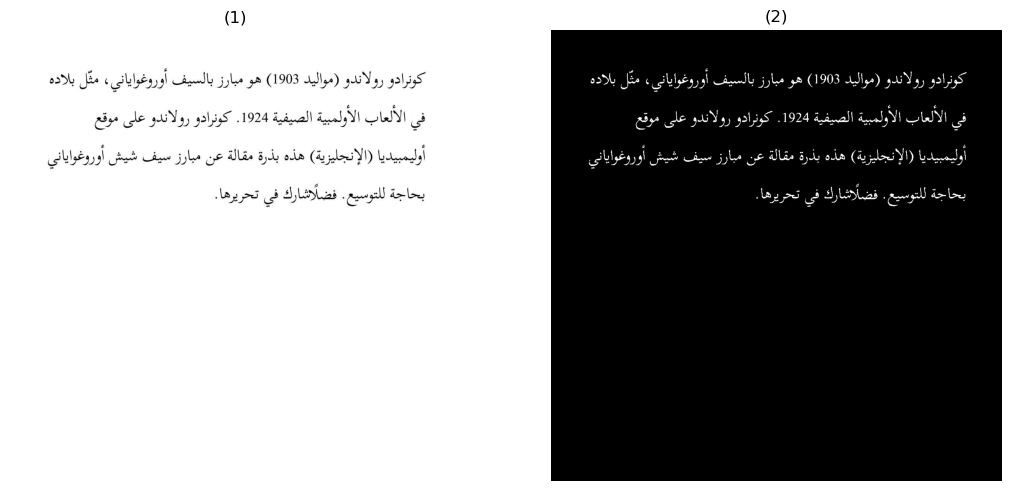

In [215]:
# def preprocess(image):

#     # Maybe we end up using only gray level image.
#     # gray_img = cv.bitwise_not(image) # Invert the image
#     binary_img = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
#     deskewed_img = deskew(binary_img)
#     return deskewed_img


def projection_segmentation(clean_img, axis, cut=15, min_width=20, min_height=30):
    """Segment the image based on the projection profile

    Args:
        clean_img : Preprocessed image
        axis (str): 'horizontal' or 'vertical'
        cut (int, optional): Gap between the segments. Defaults to 3.
        min_width (int, optional): Width of the segment. Defaults to 5.
        min_height (int, optional): Height of the segment. Defaults to 5.

    Returns:
        _type_: _description_
    """
    segments = []
    start = -1
    cnt = 0

    projection_bins = projection(clean_img, axis)
    for idx, projection_bin in enumerate(projection_bins):

        if projection_bin != 0:
            cnt = 0
        if projection_bin != 0 and start == -1:
            start = idx
        if projection_bin == 0 and start != -1:
            cnt += 1
            if cnt >= cut:
                if axis == 'horizontal':
                    # Line segmentation
                    segment = clean_img[max(start-1, 0):idx, :]
                    if segment.shape[0] >= min_height:                    
                        segments.append(segment)
                elif axis == 'vertical':
                    # Word segmentation
                    segment = clean_img[:, max(start-1, 0):idx]
                    if segment.shape[1] >= min_width:
                        segments.append(segment)
                cnt = 0
                start = -1
    
    return segments


# Line Segmentation
#----------------------------------------------------------------------------------------
def line_horizontal_projection(image, cut=3):

    # Segmentation    
    lines = projection_segmentation(image, axis='horizontal', cut=cut)
    return lines


# Word Segmentation
#----------------------------------------------------------------------------------------
def word_vertical_projection(line_image, cut=3):
    
    line_words = projection_segmentation(line_image, axis='vertical', cut=cut)
    line_words.reverse()
    return line_words


def extract_words(img, visual=0):

    lines = line_horizontal_projection(img)
    words = []
    
    for idx, line in enumerate(lines):
        
        if visual:
            # Check for the size of the line to be greater than 30
            # if line.shape[0] > 30:
            save_image(line, 'lines', f'line{idx}')

        line_words = word_vertical_projection(line)
        for w in line_words:
            # if len(words) == 585:
            #     print(idx)
            words.append((w, line))
        # words.extend(line_words)

    # breakpoint()
    if visual:
        for idx, word in enumerate(words):
            # check for the size of the word to be greater than 30
            # print (word[0].shape)
            # if word[0].shape[0] < 100 and word[0].shape[1] > 20 :
            save_image(word[0], 'words', f'word{idx}')
    return words

# Try to extract the words from the preprocessed images
p = preprocess(X_train[999])

show_images([X_train[999],p])

# Extract the words from the preprocessed images
words = extract_words(p, visual=1)




In [ ]:
# # Extract the words from the images
# words = []
# for i in tqdm(X_train_preprocess):
#     words.extend(extract_words(i))

# # Extract the features from the words
# features = []
# for word, line in tqdm(words):
#     features.append(cv.resize(word, (30, 30)).flatten())
    